In [1]:
import numpy as np
import time
import random
import pylab
from hrr import *
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Number of training cycles
episodes = 50000

# Hrr parameters
hrr_length = 5120
normalized = True

# How many steps to take before quiting
steps_till_quit = 100

signals = ["I"]
goals = [[5], [10], [15]]

# Maze parameters
size_of_maze = 20
non_obs_task_switch_rate = 250
num_non_obs_tasks = len(goals)
num_obs_tasks = len(signals)

if num_non_obs_tasks == 1:
    goals = goals[0]
    num_non_obs_tasks = 0
if num_obs_tasks == 1:
    goals = sum(goals, [])
    num_obs_tasks = 0

# Arguments for neural network
input_size = hrr_length
output_size = 1
discount = 0.75
alpha = 0.1

# Reward for temporal difference learning
reward_bad = 0
reward_good = 1

# Expolration rate
e_soft = 0.0001
rand_on = 1

# Threshold for non observable task switching
threshold_negative = -0.3
treshold_positive = 0.7

# Print frequency
p_freq = 1000

# Eligibility trace
eligibility = np.zeros(hrr_length)

# Eligibility trace rate
eli_lambda = 0.0

# Neural network
weights = hrr(hrr_length, normalized)
bias = 1

debug = False

In [3]:
def get_moves(state, size_of_maze):
    if(state == 0):
        return size_of_maze - 1, 1
    elif(state == size_of_maze - 1):
        return size_of_maze - 2, 0
    else:
        return state - 1, state + 1

In [4]:
def build_hrr_string(wm, signal, state, atr):
    if wm == "I" and signal == "I":
        return "State:" + str(state) + "*" + "Atr:" + str(atr)
    elif wm == "I":
        return "Signal:" + str(signal) + "*" + "State:" + str(state) + "*" + "Atr:" + str(atr)
    elif signal == "I":
        return "WM:" + str(wm) + "*" + "State:" + str(state) + "*" + "Atr:" + str(atr)
    else:
        return "WM:" + str(wm) + "*" + "Signal:" + str(signal) + "*" + "State:" + str(state) + "*" + "Atr:" + str(atr)

In [5]:
def context_policy_negative(atr):
    return (atr + 1)%num_non_obs_tasks

In [6]:
def context_policy_positive(wm, signal, state, atr):
    val = -9999
    temp = -9999
    
    for atr in range(0, num_non_obs_tasks):
        encode_str = build_hrr_string(wm, signal, state, atr)
        temp = np.dot(weights, ltm.encode(encode_str)) + bias
        if temp > val:
            val = temp
            s_atr = atr
            
    return s_atr

In [7]:
def move_policy(goal, moves, wms, signals, atr, rand_on):
    
    val = -9999
    temp = -9999
    
    for move in moves:
        for wm in list(dict.fromkeys(wms + ["I"])):
            for signal in list(dict.fromkeys(signals + ["I"])):
                if move == goal:
                    encode_str = build_hrr_string(wm, signal, str(move) + "*rewardTkn", atr)
                else:
                    encode_str = build_hrr_string(wm, signal, str(move), atr)
                if (debug):
                    print(encode_str)
                temp = np.dot(weights, ltm.encode(encode_str)) + bias
                if debug:
                    if signal != "I":
                        print("Move: {0}, WM: {1}, Signal: {2}In, Atr: {3}, Value: {4}".format(move, wm, signal, atr, temp))
                    else:
                        print("Move: {0}, WM: {1}, Signal: {2}, Atr: {3}, Value: {4}".format(move, wm, signal, atr, temp))
                if temp > val:
                    val = temp
                    s_move = move
                    if signal != "I":
                        s_wm = signal + "In"
                    else:
                        s_wm = wm
            
    # Random move
    if(np.random.random_sample() < e_soft) and rand_on:
        if(debug):
            print("RANDOM MOVE")
        return (np.random.choice(moves), wm, atr, 1)
    
    return (s_move, s_wm, atr, 0)

In [8]:
def get_opt_steps(start, goal, size_of_maze):
    opt = abs(goal - start)
    if opt > size_of_maze / 2:
        opt = size_of_maze - opt
    return opt

In [9]:
def logmod(x):
    return np.sign(x)*np.log(abs(x)+1)

In [10]:
ltm = LTM(hrr_length, normalized)
ltm.print()

I [1. 0. 0. ... 0. 0. 0.]


In [11]:
t0 = time.time()

In [12]:
non_obs = 0
current_atr = 0
current_wm = "I"

debug2 = False
step_store = []

for x in range(episodes):
        
    current_state = random.randint(0, size_of_maze - 1)
    current_signal = np.random.choice(signals)
    
    if num_non_obs_tasks == 0:
        goal = goals[signals.index(current_signal)]
    elif num_obs_tasks == 0:
        if x%non_obs_task_switch_rate == 0:
            non_obs = (non_obs+1)%num_non_obs_tasks
        goal = goals[non_obs]
    else:
        if x%non_obs_task_switch_rate == 0:
            non_obs = (non_obs+1)%num_non_obs_tasks
        goal = goals[non_obs][signals.index(current_signal)]
        
    steps = 0
    opt_steps = get_opt_steps(current_state, goal, size_of_maze)
    
    # Reset trace
    eligibility *= 0.0
    
    
    if x > ((episodes * 5) / 10) :
        debug2 = True
        rand_on = 0
        alpha = 0.01
    
    if debug:
        print("Goal: {0}, Signal: {1}, Non_Observable: {2}".format(goal, current_signal, non_obs))
        
    episode_memory = []
    for y in range(steps_till_quit):
        if (current_state == goal):
            encode_str = build_hrr_string(current_wm, current_signal, str(current_state) + "*rewardTkn", current_atr)
            goal_hrr = ltm.encode(encode_str)
            goal_value = np.dot(weights, goal_hrr) + bias
            episode_memory += [[current_state, current_value, goal]]

            error = reward_good - goal_value
            eligibility *= eli_lambda
            eligibility = eligibility + goal_hrr
            weights = np.add(weights, (alpha * logmod(error) * eligibility))
            
            if(debug):
                print("In goal with value {0}".format(goal_value))
            
            break
            
        
        # Store info about previous state      
        previous_wm = current_wm
        previous_signal = current_signal
        previous_state = current_state
        previous_atr = current_atr
        
        if debug:
            print("Previous WM:, {0}, Signal:, {1}, State, {2}, ATR:, {3}".format(previous_wm, previous_signal, previous_state, previous_atr))
        
        encode_str = build_hrr_string(previous_wm, previous_signal, previous_state, previous_atr)
        previous_state_hrr = ltm.encode(encode_str)
        previous_value = np.dot(weights, previous_state_hrr) + bias
        
        if debug:
            print("Started with state: {0}, State Value: {1}, WM: {2},  Atr: {3}".format(previous_state, previous_value, previous_wm, previous_atr))
            
        current_signal = "I"
        left, right = get_moves(previous_state, size_of_maze)
        if previous_signal != "I":
            previous_signal += "In"

        # Make the move
        move, wm, atr, random_move = move_policy(goal, [left, right], [previous_wm, previous_signal], [current_signal], previous_atr, rand_on)
        steps += 1
        
        current_wm = wm
        current_state = move
        current_atr = atr
        
        if random_move:
            eligibility *= 0.0
            
        if(debug):
            print("Moves {0}, taken {1}".format([left, right], move))
            
        if debug:
            print("Current WM {0}, Current Signal {1}, Current state {2}, Current ATR {3}".format(current_wm, current_signal, current_state, current_atr))
            
        if current_state == goal:
            encode_str = build_hrr_string(current_wm, current_signal, str(current_state) + "*rewardTkn", current_atr)     
            if debug:
                print("In goal: WM: {1}, ATR: {2}".format(current_wm, current_atr))
        else:
            encode_str = build_hrr_string(current_wm, current_signal, current_state, current_atr)
            
        current_state_hrr = ltm.encode(encode_str)
        current_value = np.dot(weights, current_state_hrr) + bias
        
        sarsa_error = (reward_bad + discount * current_value) - previous_value
        eligibility *= eli_lambda
        eligibility = eligibility + previous_state_hrr
        if sarsa_error > treshold_positive and num_non_obs_tasks > 0:
            current_atr = context_policy_positive(current_wm, current_signal, current_state, current_atr)
            weights = np.add(weights, (alpha * logmod(sarsa_error) * eligibility))
            eligibility *= 0.0
            steps = 0
            opt_steps = get_opt_steps(current_state, goal, size_of_maze)
            if(debug):
                print("Changed atr from {0} to {1}".format(previous_atr, current_atr))
        if sarsa_error < threshold_negative and num_non_obs_tasks > 0:
            current_atr = context_policy_negative(previous_atr)
            weights = np.add(weights, (alpha * logmod(sarsa_error) * eligibility))
            eligibility *= 0.0
            steps = 0
            opt_steps = get_opt_steps(current_state, goal, size_of_maze)
            if(debug):
                print("Changed atr from {0} to {1}".format(previous_atr, current_atr))
        weights = np.add(weights, (alpha * sarsa_error * eligibility))
        
        if debug:
            input("")
        
    # if debu*g2 and steps-opt_steps:
    #    print(np.array(episode_memory))
    
    if(debug2):
        step_store += [steps - opt_steps]
        
    if((x+1)%p_freq == 0):
        print("Episode" , x+1, "done")

Episode 1000 done
Episode 2000 done
Episode 3000 done
Episode 4000 done
Episode 5000 done
Episode 6000 done
Episode 7000 done
Episode 8000 done
Episode 9000 done
Episode 10000 done
Episode 11000 done
Episode 12000 done
Episode 13000 done
Episode 14000 done
Episode 15000 done
Episode 16000 done
Episode 17000 done
Episode 18000 done
Episode 19000 done
Episode 20000 done
Episode 21000 done
Episode 22000 done
Episode 23000 done
Episode 24000 done
Episode 25000 done
Episode 26000 done
Episode 27000 done
Episode 28000 done
Episode 29000 done
Episode 30000 done
Episode 31000 done
Episode 32000 done
Episode 33000 done
Episode 34000 done
Episode 35000 done
Episode 36000 done
Episode 37000 done
Episode 38000 done
Episode 39000 done
Episode 40000 done
Episode 41000 done
Episode 42000 done
Episode 43000 done
Episode 44000 done
Episode 45000 done
Episode 46000 done
Episode 47000 done
Episode 48000 done
Episode 49000 done
Episode 50000 done


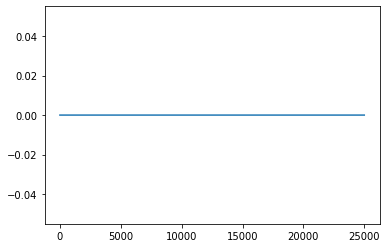

100.0

In [13]:
plt.plot(step_store)
plt.show()
(len(step_store)-np.count_nonzero(step_store))*100.0 / len(step_store)

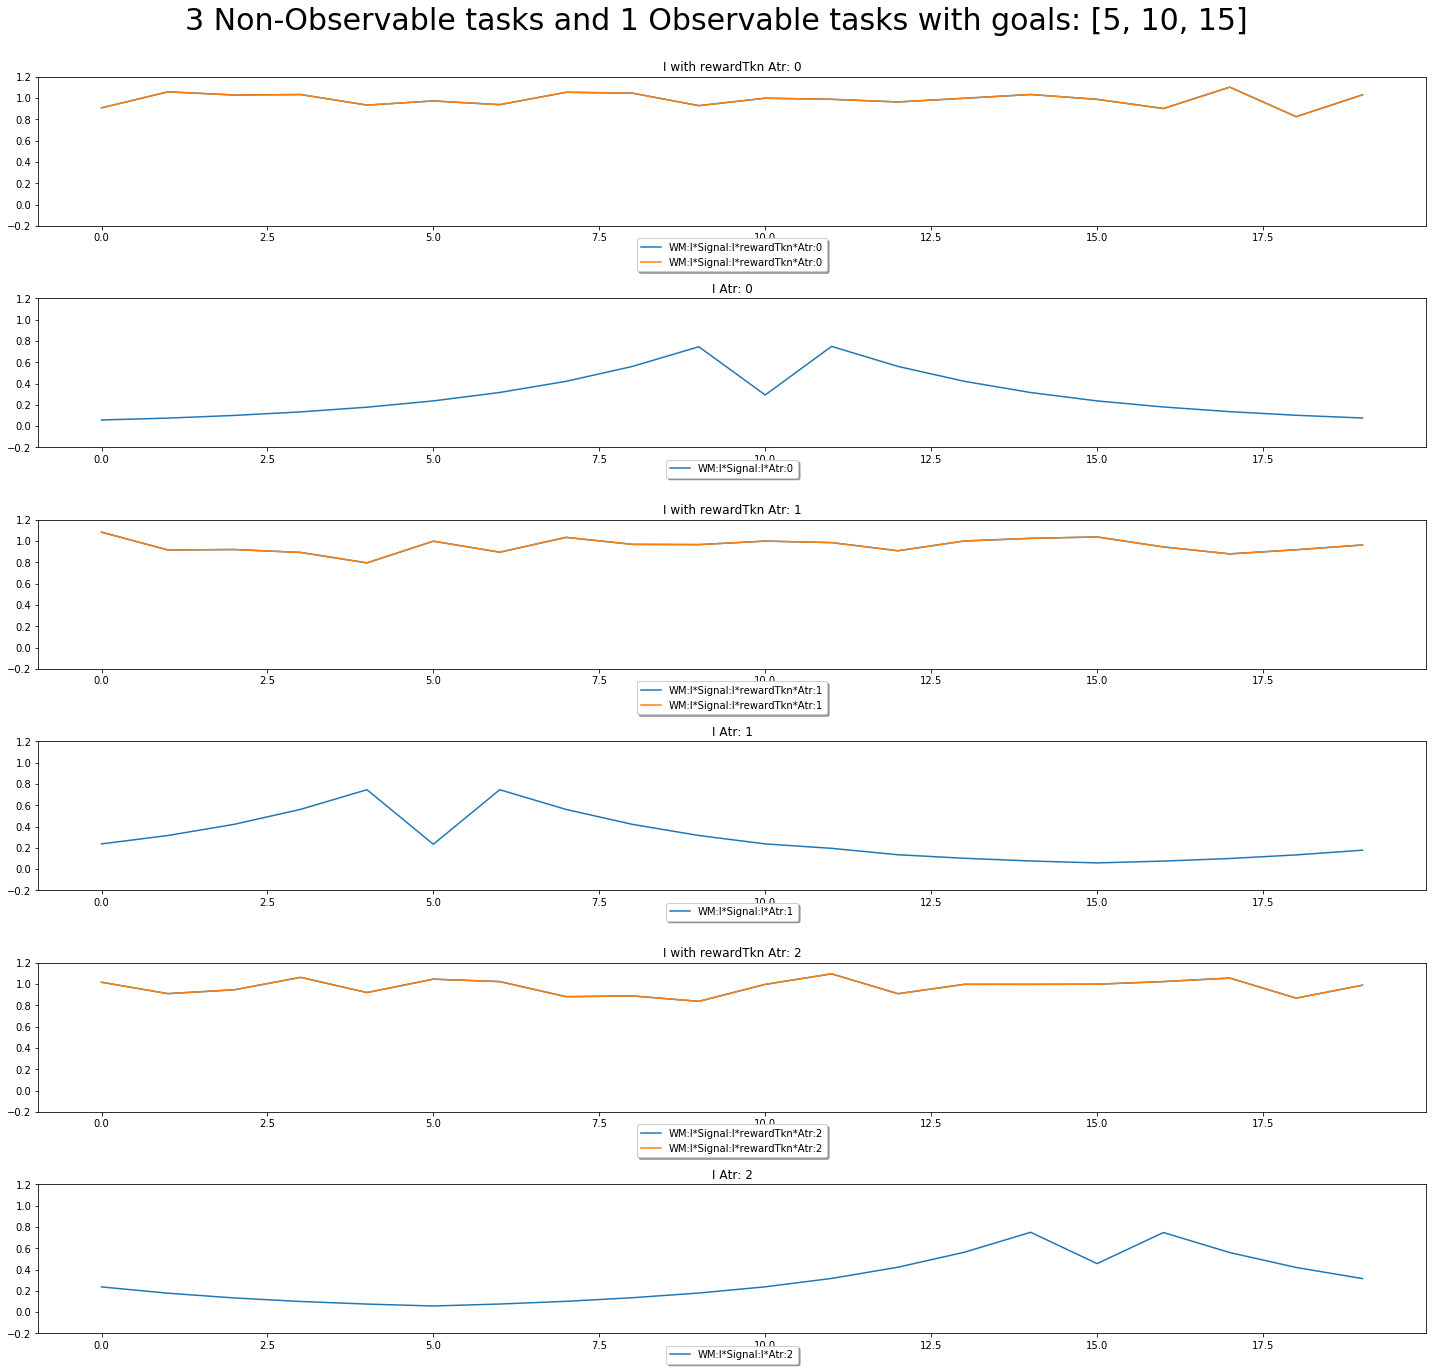

In [14]:
if num_obs_tasks == 0:
    rows = num_non_obs_tasks * 2
    cols = 1
    runs = num_non_obs_tasks
elif num_non_obs_tasks == 0:
    rows = 2
    cols = num_obs_tasks+1
    runs = 1
else:
    rows = num_non_obs_tasks * 2
    cols = num_obs_tasks+1
    runs = num_non_obs_tasks

fig, axes = plt.subplots(nrows=rows, ncols=cols)
fig.set_figwidth(20)
fig.set_figheight(20)

for x in range(runs):
    
    x_ind = x * 2
    y_for_rwd = 0
    y_for_no_rwd = 0
    
    if cols != 1:
        for wm in list(dict.fromkeys([signal + "In" if signal != "I" else signal for signal in signals] + ["I"])):
            position = np.arange(size_of_maze)
            value = np.zeros(size_of_maze)
            for signal in signals + ["I"]:
                lab = "WM:" + wm + "*Signal:" + signal + "*rewardTkn*Atr:" + str(x)
                for state in range(size_of_maze):
                    encode_str = build_hrr_string(wm, signal, str(state) + "*rewardTkn", x)
                    value[state] = np.dot(weights, ltm.encode(encode_str)) + bias
                axes[x_ind,y_for_rwd].title.set_text(wm + " with rewardTkn " + "Atr: " + str(x))
                axes[x_ind,y_for_rwd].set_ylim([-0.2, 1.2])
                axes[x_ind,y_for_rwd].plot(position, value, label=lab)

                axes[x_ind,y_for_rwd].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
                      fancybox=True, shadow=True, ncol=1, prop={'size': 10})
            y_for_rwd += 1

            y = x + 1
            value = np.zeros(size_of_maze)
            for signal in list(dict.fromkeys(signals + ["I"])):
                lab = "WM:" + wm + "*Signal:" + signal + "*Atr:" + str(x)
                for state in range(size_of_maze):
                    encode_str = build_hrr_string(wm, signal, str(state), x)
                    value[state] = np.dot(weights, ltm.encode(encode_str)) + bias
                axes[x_ind+1,y_for_no_rwd].title.set_text(wm + " Atr: " + str(x))
                axes[x_ind+1,y_for_no_rwd].set_ylim([-0.2, 1.2])
                axes[x_ind+1,y_for_no_rwd].plot(position, value, label=lab)
                axes[x_ind+1,y_for_no_rwd].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
                      fancybox=True, shadow=True, ncol=1, prop={'size': 10})
            y_for_no_rwd += 1   
    else:
        for wm in list(dict.fromkeys([signal + "In" if signal != "I" else signal for signal in signals] + ["I"])):
            position = np.arange(size_of_maze)
            value = np.zeros(size_of_maze)
            for signal in signals + ["I"]:
                lab = "WM:" + wm + "*Signal:" + signal + "*rewardTkn*Atr:" + str(x)
                for state in range(size_of_maze):
                    encode_str = build_hrr_string(wm, signal, str(state) + "*rewardTkn", x)
                    value[state] = np.dot(weights, ltm.encode(encode_str)) + bias
                axes[x_ind].title.set_text(wm + " with rewardTkn " + "Atr: " + str(x))
                axes[x_ind].set_ylim([-0.2, 1.2])
                axes[x_ind].plot(position, value, label=lab)

                axes[x_ind].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
                      fancybox=True, shadow=True, ncol=1, prop={'size': 10})
            y_for_rwd += 1

            y = x + 1
            value = np.zeros(size_of_maze)
            for signal in list(dict.fromkeys(signals + ["I"])):
                lab = "WM:" + wm + "*Signal:" + signal + "*Atr:" + str(x)
                for state in range(size_of_maze):
                    encode_str = build_hrr_string(wm, signal, str(state), x)
                    value[state] = np.dot(weights, ltm.encode(encode_str)) + bias
                axes[x_ind+1].title.set_text(wm + " Atr: " + str(x))
                axes[x_ind+1].set_ylim([-0.2, 1.2])
                axes[x_ind+1].plot(position, value, label=lab)
                axes[x_ind+1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
                      fancybox=True, shadow=True, ncol=1, prop={'size': 10})
            y_for_no_rwd += 1

plt.suptitle(str(len(goals)) + " Non-Observable tasks and " + str(len(signals)) + " Observable tasks with goals: "+ str(goals), fontsize=30)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
t1 = time.time()

In [15]:
ltm.print()

I [1. 0. 0. ... 0. 0. 0.]
Atr:0 [-0.00012902  0.00885131  0.02680577 ...  0.01693129  0.00930747
 -0.00352881]
State:17 [-0.0013293   0.00165133  0.00275363 ... -0.03147039  0.01154509
  0.01928969]
Atr:0*State:17 [-0.00679608  0.02476946  0.01320206 ...  0.00291536 -0.00633181
 -0.0136858 ]
State:16 [ 0.00655674 -0.00674874  0.01982073 ...  0.01810595 -0.01277089
  0.01692341]
Atr:0*State:16 [-0.0037177   0.00298631 -0.00993306 ...  0.00261613 -0.00843878
  0.01154185]
State:18 [ 0.00058875 -0.00380673  0.0188903  ... -0.00684414 -0.01327981
  0.00439776]
Atr:0*State:18 [-0.00871782 -0.00013714 -0.00662663 ... -0.00809957  0.00163142
  0.00419133]
State:15 [ 0.01731217 -0.01086962  0.01525499 ...  0.01128233  0.0177878
  0.00233422]
Atr:0*State:15 [ 0.0198537   0.00726677  0.01143505 ... -0.01590809  0.00138011
 -0.00717206]
State:14 [-0.01562626 -0.00897175  0.01351772 ...  0.01639224  0.00571587
 -0.01121203]
Atr:0*State:14 [-0.00238868 -0.02557809 -0.01657713 ... -0.00169036  0.020

In [16]:
del ltm